In [ ]:
import sys
import numpy as np
import scipy.io
import torch
from pyDOE import lhs
from torch import Tensor, ones, stack, load
from torch.autograd import grad
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import pandas as pd
from torch.nn import Module
from torch.utils.data import DataLoader
from scipy import stats

sys.path.append('/content/drive/MyDrive/NeuralSolvers-master')  # PINNFramework etc.
import PINNFramework as pf

Was not able to import Horovod. Thus Horovod support is not enabled


In [ ]:
# import "tesla_driving_temp_data.csv"
df = pd.read_csv('/content/drive/MyDrive/NeuralSolvers-master/examples/1D_HeatEquation/MLP/Experiment MLP/tesla_driving_temp_data.csv')

In [ ]:
#[power, speed, battery_level, outside_temp] => [battery_temperature]
#[power, speed, battery_level, outside_temp, battery_temperature] => [delta_battery_temperature]

In [ ]:
df0=df[df['drive_id'] == 50] # dataset for index=50
#true = df50[["battery_temperature"]]
dreal=df0
dreal
print((df0))
print((df0.shape))
df0=df
#df0=df

        Unnamed: 0  speed  ...  battery_temperature  drive_id
141138           0    0.0  ...            19.380603        50
141139           1    0.0  ...            19.381268        50
141140           2    0.0  ...            19.382060        50
141141           3    2.0  ...            19.383227        50
141142           4    2.0  ...            19.383812        50
...            ...    ...  ...                  ...       ...
142313        1175    2.0  ...            19.823006        50
142314        1176    0.0  ...            19.823423        50
142315        1177    0.0  ...            19.823839        50
142316        1178    0.0  ...            19.825091        50
142317        1179    0.0  ...            19.825091        50

[1180 rows x 10 columns]
(1180, 10)


In [ ]:
df0['date'].shape

(445266,)

In [ ]:
#testdata['time'].dt.tz_localize(None)
#pd.to_datetime
#df0['date'].to_datetime

#df['concant_time'] =  pd.to_datetime(df['concant_time'], format = "%m/%d/%Y %H:%M:00") # transfrom string to datetime
#df['time_diff'] = 0 #initialize column to assign running time diff.

#df0.info()
df0['date']= pd.to_datetime(df0['date'])

In [ ]:
print(type(df0['date']))
df0['date']

<class 'pandas.core.series.Series'>


0         2021-01-30 16:46:58.419000+01:00
1         2021-01-30 16:47:14.563000+01:00
2         2021-01-30 16:47:30.740000+01:00
3         2021-01-30 16:47:46.840000+01:00
4         2021-01-30 16:48:02.982000+01:00
                        ...               
445261    2021-05-23 11:15:03.452000+02:00
445262    2021-05-23 11:15:03.702000+02:00
445263    2021-05-23 11:15:04.452000+02:00
445264    2021-05-23 11:15:05.999000+02:00
445265    2021-05-23 11:15:05.999000+02:00
Name: date, Length: 445266, dtype: object

In [ ]:
df0['date'].head()

0    2021-01-30 16:46:58.419000+01:00
1    2021-01-30 16:47:14.563000+01:00
2    2021-01-30 16:47:30.740000+01:00
3    2021-01-30 16:47:46.840000+01:00
4    2021-01-30 16:48:02.982000+01:00
Name: date, dtype: object

In [ ]:
df0['time'] = df0['date'] - df0['date'].iloc[0]
print(df0['time'].shape)
print(df0['time'])

(445266,)
0                 0 days 00:00:00
1          0 days 00:00:16.144000
2          0 days 00:00:32.321000
3          0 days 00:00:48.421000
4          0 days 00:01:04.563000
                   ...           
445261   112 days 17:28:05.033000
445262   112 days 17:28:05.283000
445263   112 days 17:28:06.033000
445264   112 days 17:28:07.580000
445265   112 days 17:28:07.580000
Name: time, Length: 445266, dtype: timedelta64[ns]


In [ ]:
df0['time']

0                 0 days 00:00:00
1          0 days 00:00:16.144000
2          0 days 00:00:32.321000
3          0 days 00:00:48.421000
4          0 days 00:01:04.563000
                   ...           
445261   112 days 17:28:05.033000
445262   112 days 17:28:05.283000
445263   112 days 17:28:06.033000
445264   112 days 17:28:07.580000
445265   112 days 17:28:07.580000
Name: time, Length: 445266, dtype: timedelta64[ns]

In [ ]:
#df[:5]['duration'] / np.timedelta64(1, 's')
#df0['time_diff'][1:]
df0['time'] = df0['time'][1:]/ np.timedelta64(1, 's')
print(df0['time'])

0                 NaN
1              16.144
2              32.321
3              48.421
4              64.563
             ...     
445261    9739685.033
445262    9739685.283
445263    9739686.033
445264    9739687.580
445265    9739687.580
Name: time, Length: 445266, dtype: float64


In [ ]:
df0['time'].iloc[0] = 0
df0['time']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


0               0.000
1              16.144
2              32.321
3              48.421
4              64.563
             ...     
445261    9739685.033
445262    9739685.283
445263    9739686.033
445264    9739687.580
445265    9739687.580
Name: time, Length: 445266, dtype: float64

In [ ]:
df0['delta_t'] = df0['time'].diff(periods=-1)*(-1)
print(df0['delta_t'])
df0['delta_t'] = df0['delta_t'].interpolate()
print(df0['delta_t'])

0         16.144
1         16.177
2         16.100
3         16.142
4         16.118
           ...  
445261     0.250
445262     0.750
445263     1.547
445264    -0.000
445265       NaN
Name: delta_t, Length: 445266, dtype: float64
0         16.144
1         16.177
2         16.100
3         16.142
4         16.118
           ...  
445261     0.250
445262     0.750
445263     1.547
445264    -0.000
445265    -0.000
Name: delta_t, Length: 445266, dtype: float64


In [ ]:
# Interpolate the missing data
df0['outside_temp'] = df0['outside_temp'].interpolate()
df0['speed'] = df0['speed'].interpolate()


In [ ]:
# Compute deltaTemp and add an additional column to dataset
df0['deltaTemp'] = df0['battery_temperature'].diff(periods=-1)*(-1)
#Interpolate deltaTemp
df0['deltaTemp'] = df0['deltaTemp'].interpolate()

In [ ]:
df0['deltaTemp']

0         0.002691
1         0.002696
2         0.002683
3         0.002690
4         0.002686
            ...   
445261   -0.000042
445262   -0.000125
445263   -0.000258
445264   -0.000000
445265   -0.000000
Name: deltaTemp, Length: 445266, dtype: float64

In [ ]:
#df0

In [ ]:
df0['Differentiation'] = df0['deltaTemp']/df0['delta_t']
print(df0['Differentiation'])

0         0.000167
1         0.000167
2         0.000167
3         0.000167
4         0.000167
            ...   
445261   -0.000167
445262   -0.000167
445263   -0.000167
445264         NaN
445265         NaN
Name: Differentiation, Length: 445266, dtype: float64


In [ ]:
# Remove values larger than 0.1
remove=(df0['Differentiation'][np.isnan(df0['Differentiation']) == True].index.values)
df0 = df0.drop(remove)
#(np.isnan(a))

In [ ]:
df0.shape

(445135, 14)

In [ ]:
df0

,Unnamed: 0,speed,power,battery_level,outside_temp,battery_heater,battery_heater_on,date,battery_temperature,drive_id,time,delta_t,deltaTemp,Differentiation
0,65,26.0,11,94,0.5,False,False,2021-01-30 16:46:58.419000+01:00,12.946570,0,0.000,16.144,0.002691,0.000167
1,66,32.0,6,94,0.5,False,False,2021-01-30 16:47:14.563000+01:00,12.949260,0,16.144,16.177,0.002696,0.000167
2,67,27.0,-5,93,0.5,False,False,2021-01-30 16:47:30.740000+01:00,12.951957,0,32.321,16.100,0.002683,0.000167
3,68,31.0,12,93,0.5,False,False,2021-01-30 16:47:46.840000+01:00,12.954640,0,48.421,16.142,0.002690,0.000167
4,69,10.0,4,93,0.5,False,False,2021-01-30 16:48:02.982000+01:00,12.957330,0,64.563,16.118,0.002686,0.000167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445259,197,2.0,1,100,15.0,NaN,NaN,2021-05-23 11:15:01.452000+02:00,18.549758,98,9739683.033,1.000,-0.000167,-0.000167
445260,198,2.0,1,100,15.0,NaN,NaN,2021-05-23 11:15:02.452000+02:00,18.549591,98,9739684.033,1.000,-0.000167,-0.000167
445261,199,2.0,1,100,15.0,NaN,NaN,2021-05-23 11:15:03.452000+02:00,18.549425,98,9739685.033,0.250,-0.000042,-0.000167
445262,200,0.0,1,100,15.0,NaN,NaN,2021-05-23 11:15:03.702000+02:00,18.549383,98,9739685.283,0.750,-0.000125,-0.000167


In [ ]:
print(df0['Differentiation'])

0         0.000167
1         0.000167
2         0.000167
3         0.000167
4         0.000167
            ...   
445259   -0.000167
445260   -0.000167
445261   -0.000167
445262   -0.000167
445263   -0.000167
Name: Differentiation, Length: 445135, dtype: float64


In [ ]:
#df0=df0[df0['drive_id'] == 0]

In [ ]:
# Extract features and labels for all dataset
#df0[["time"]]=df0[["time"]]/60
df_x = df0[["time","power","speed", "battery_level", "outside_temp", "battery_temperature"]]
df_y = df0[["Differentiation"]]*1000

df_x_tensor = (torch.tensor(df_x.values)).float()
#[1:]
df_y_tensor = torch.tensor(df_y.values).float()
#[1:]
print(type(df_x_tensor[0]))
print(type(df_y_tensor[0]))
#print(df_y_tensor)

<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [ ]:
df_x_tensor.shape

torch.Size([445135, 6])

In [ ]:
df_y_tensor.shape

torch.Size([445135, 1])

In [ ]:
#MLP
lb = torch.min(df_x_tensor,0).values.numpy()
ub = torch.max(df_x_tensor,0).values.numpy()
print(lb)
print(ub)

model = pf.models.MLP(input_size=6,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=lb, 
                      ub=ub)

model.cuda() #GPU

[  0.        -68.          0.         10.        -10.         -5.7899404]
[1.0800958e+07 1.6600000e+02 1.6700000e+02 1.0000000e+02 3.5500000e+01
 3.3897732e+01]


In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = torch.nn.MSELoss()

In [ ]:
df_x_tensor

tensor([[ 0.0000e+00,  1.1000e+01,  2.6000e+01,  9.4000e+01,  5.0000e-01,
          1.2947e+01],
        [ 1.6144e+01,  6.0000e+00,  3.2000e+01,  9.4000e+01,  5.0000e-01,
          1.2949e+01],
        [ 3.2321e+01, -5.0000e+00,  2.7000e+01,  9.3000e+01,  5.0000e-01,
          1.2952e+01],
        ...,
        [ 9.7397e+06,  1.0000e+00,  2.0000e+00,  1.0000e+02,  1.5000e+01,
          1.8549e+01],
        [ 9.7397e+06,  1.0000e+00,  0.0000e+00,  1.0000e+02,  1.5000e+01,
          1.8549e+01],
        [ 9.7397e+06,  1.0000e+00,  0.0000e+00,  1.0000e+02,  1.5000e+01,
          1.8549e+01]])

In [ ]:
df_y_tensor

tensor([[ 0.1667],
        [ 0.1667],
        [ 0.1667],
        ...,
        [-0.1667],
        [-0.1667],
        [-0.1667]])

In [ ]:
#prediction = model(df_x_tensor)
#print([prediction])
#print(model.parameters)

Streaming output truncated to the last 5000 lines.
Epoch  5000 Loss  0.10467077046632767
Epoch  5001 Loss  0.10491480678319931
Epoch  5002 Loss  0.10557621717453003
Epoch  5003 Loss  0.10626070946455002
Epoch  5004 Loss  0.10667948424816132
Epoch  5005 Loss  0.10667260736227036
Epoch  5006 Loss  0.10637076199054718
Epoch  5007 Loss  0.105927973985672
Epoch  5008 Loss  0.1059076339006424
Epoch  5009 Loss  0.10595812648534775
Epoch  5010 Loss  0.10720246285200119
Epoch  5011 Loss  0.1069723591208458
Epoch  5012 Loss  0.10771505534648895
Epoch  5013 Loss  0.10675863921642303
Epoch  5014 Loss  0.10647447407245636
Epoch  5015 Loss  0.10590068995952606
Epoch  5016 Loss  0.1055622398853302
Epoch  5017 Loss  0.10530079156160355
Epoch  5018 Loss  0.10518929362297058
Epoch  5019 Loss  0.10519347339868546
Epoch  5020 Loss  0.10527694225311279
Epoch  5021 Loss  0.10536690801382065
Epoch  5022 Loss  0.10540587455034256
Epoch  5023 Loss  0.10537263005971909
Epoch  5024 Loss  0.10529989749193192
Epoc

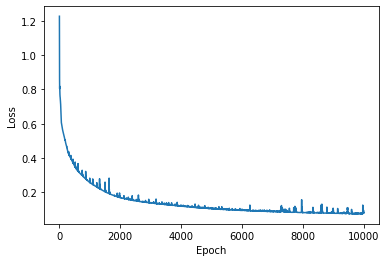

In [ ]:
x_data_plot=[]
y_data_plot=[]
Epochs = 10000
for epoch in range(Epochs):
    optimizer.zero_grad()
    prediction = model(df_x_tensor.cuda()) #GPU
    #prediction = model(df_x_tensor) #CPU
    #print(prediction)
    loss = criterion(prediction,df_y_tensor.cuda())  #GPU
    #loss = criterion(prediction, df_y_tensor) #CPU
    
    loss.backward()
    optimizer.step()
    print("Epoch ", epoch, "Loss ", loss.item())
    x_data_plot.append(epoch)
    y_data_plot.append(loss.item())

# Make the plot of all the points together
plt.plot(x_data_plot,y_data_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
plt.show()

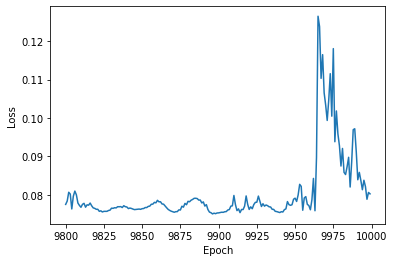

In [ ]:
# Make the plot of all the points together
plt.plot(x_data_plot[-200:],y_data_plot[-200:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
plt.show()

In [ ]:
# Make prediction
df_x_tensor=df_x_tensor
pred = model(df_x_tensor.float().cuda()) #GPU
#pred = model(df_x_tensor.float())

##pred = model(Tensor(X_star).cpu())
pred = pred.detach().cpu().numpy()

In [ ]:
df_y_tensor_np = df_y_tensor.numpy()

#comb = np.concatenate([df_y_tensor_np, pred],axis = 1)
#print(np.concatenate([df_y_tensor_np, pred],axis = 1))

print('relative l2 error:',(np.linalg.norm(df_y_tensor_np-pred)) / (np.linalg.norm(df_y_tensor_np)))

relative l2 error: 0.25963774


In [ ]:
from torch.nn import L1Loss, MSELoss

loss1 = MSELoss()
loss2 = L1Loss()
input = torch.from_numpy(pred)
target = df_y_tensor
MSE = loss1(input, target)
MAE = loss2(input, target)
print('MSE:', MSE)
print('MAE:', MAE)

MSE: tensor(0.0784)
MAE: tensor(0.1534)


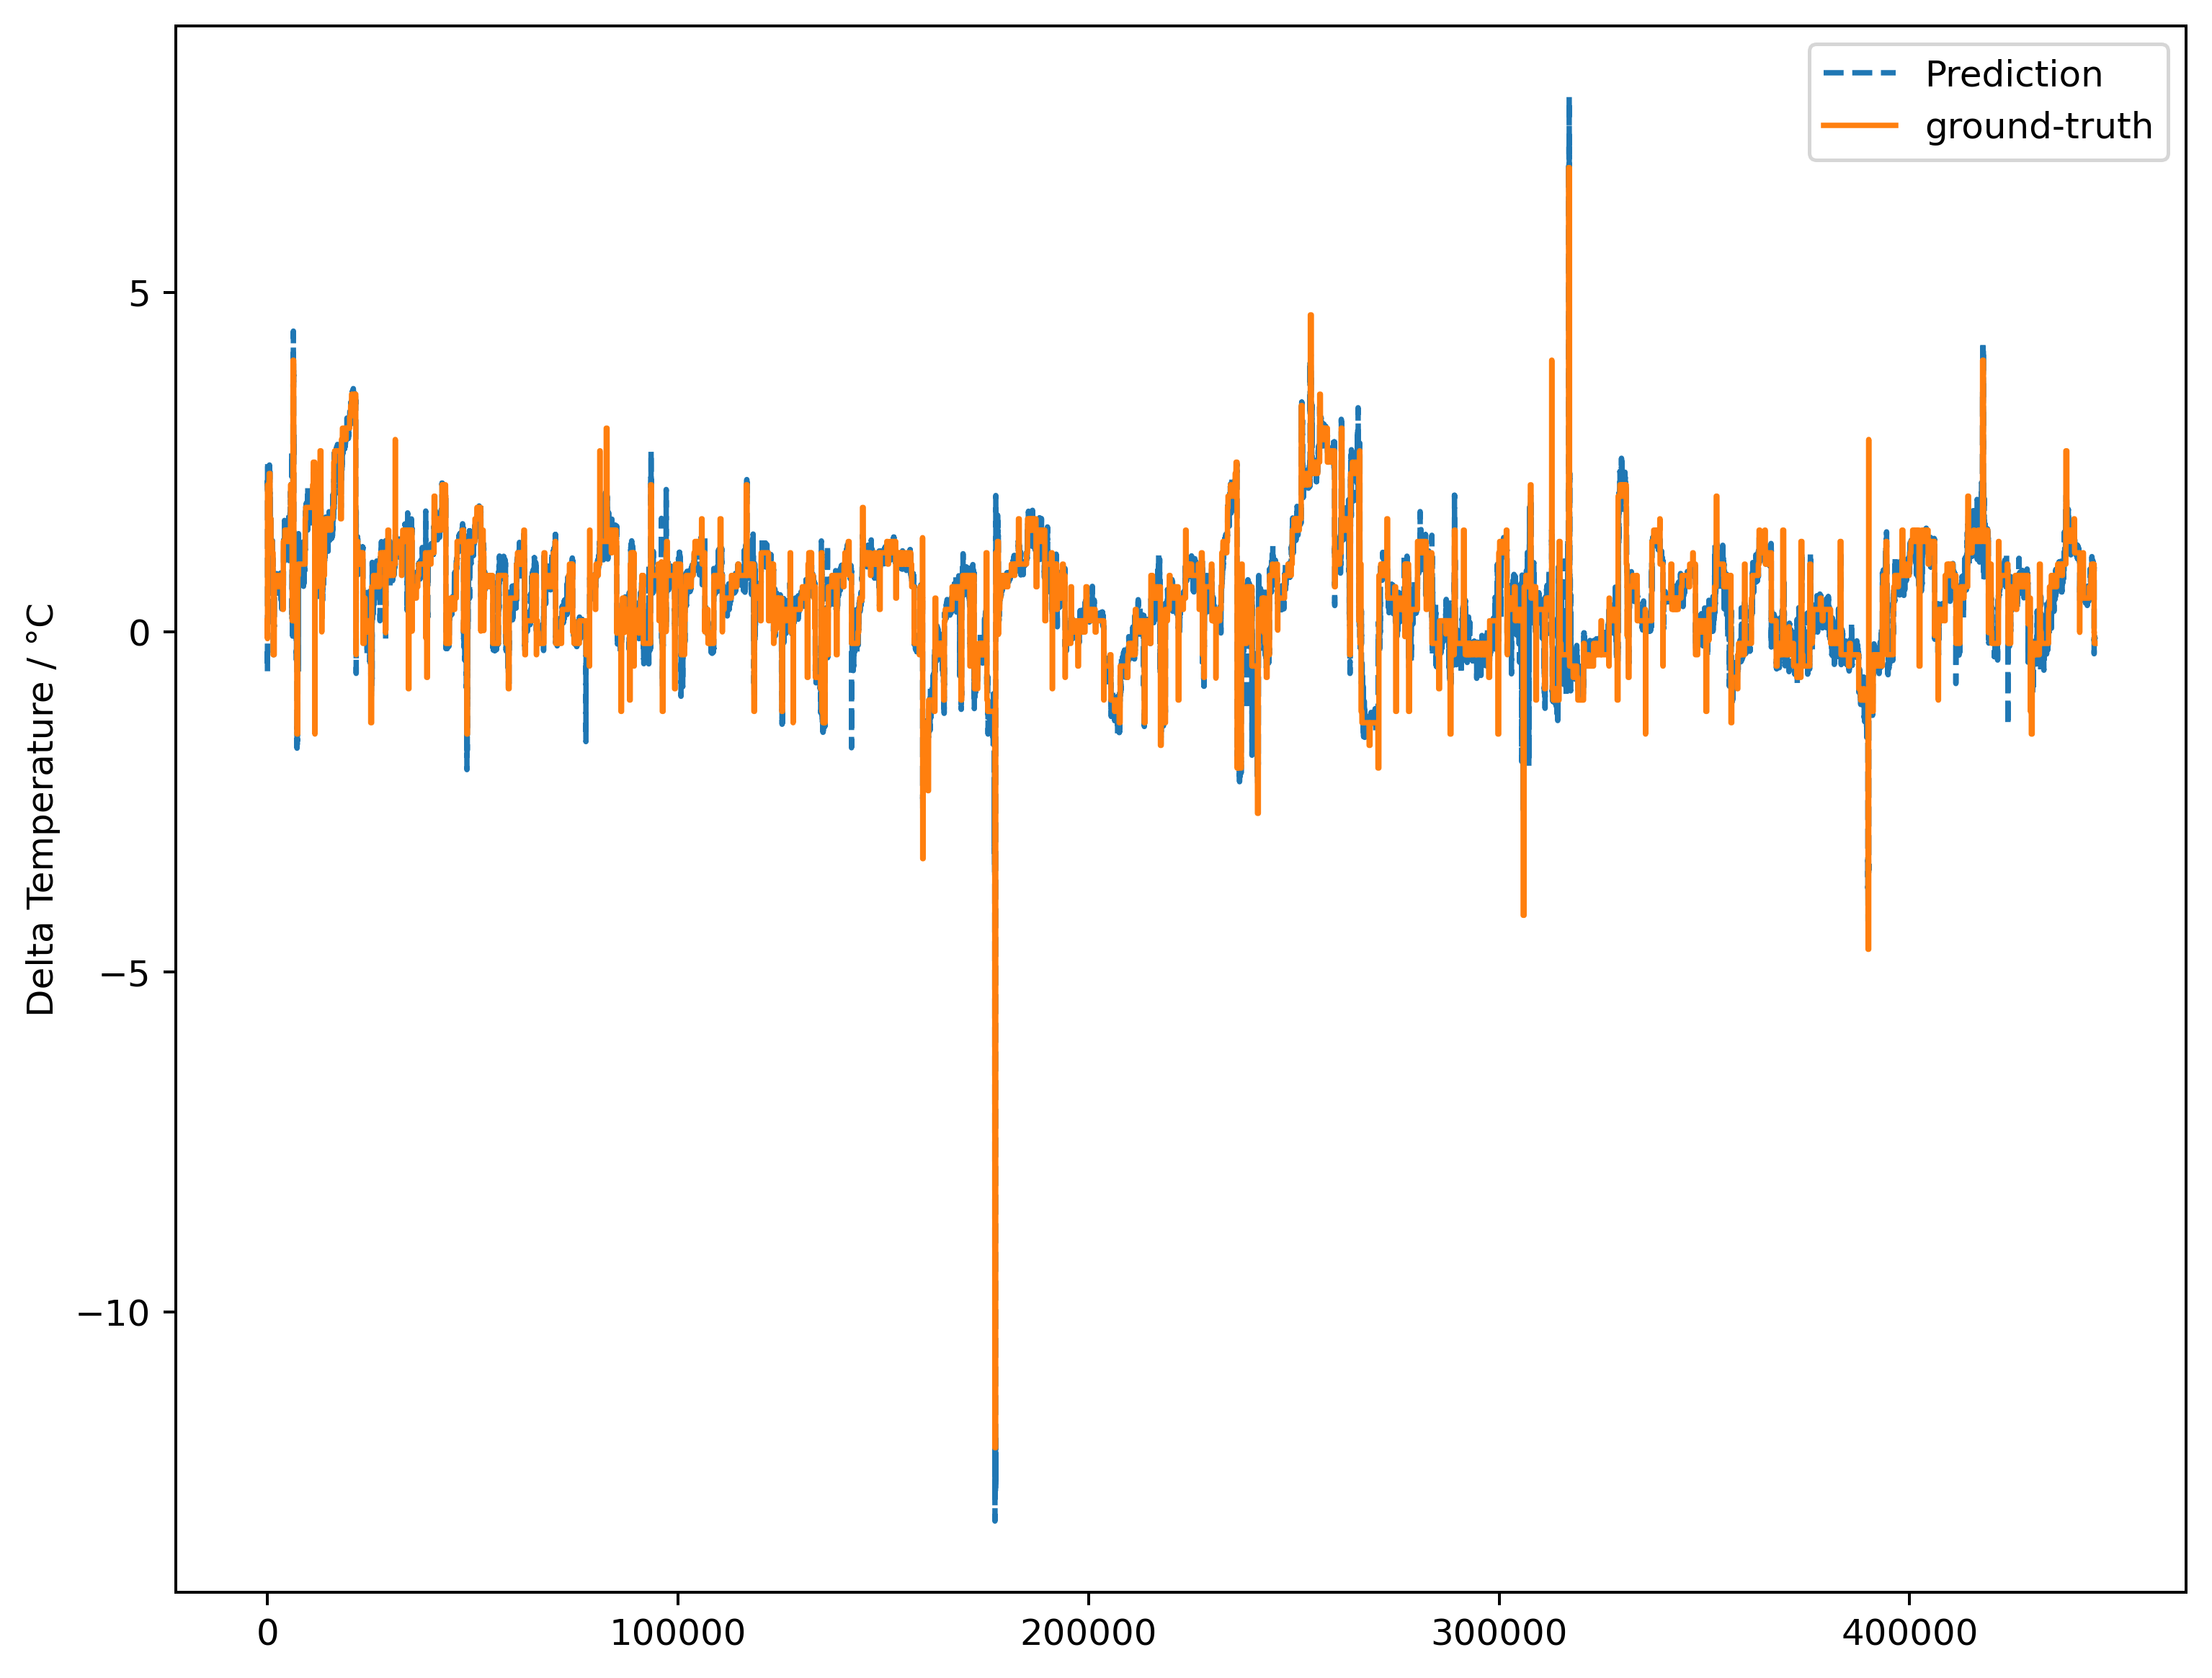

In [ ]:
figure(figsize=(10, 8), dpi= 360)

plt.plot(pred, '--')
plt.plot(df_y_tensor_np, '-')
plt.legend(['Prediction', 'ground-truth'])
#plt.xlabel('time / min')
plt.ylabel('Delta Temperature / °C')
#plt.ylim([0, 0.01])
plt.show()

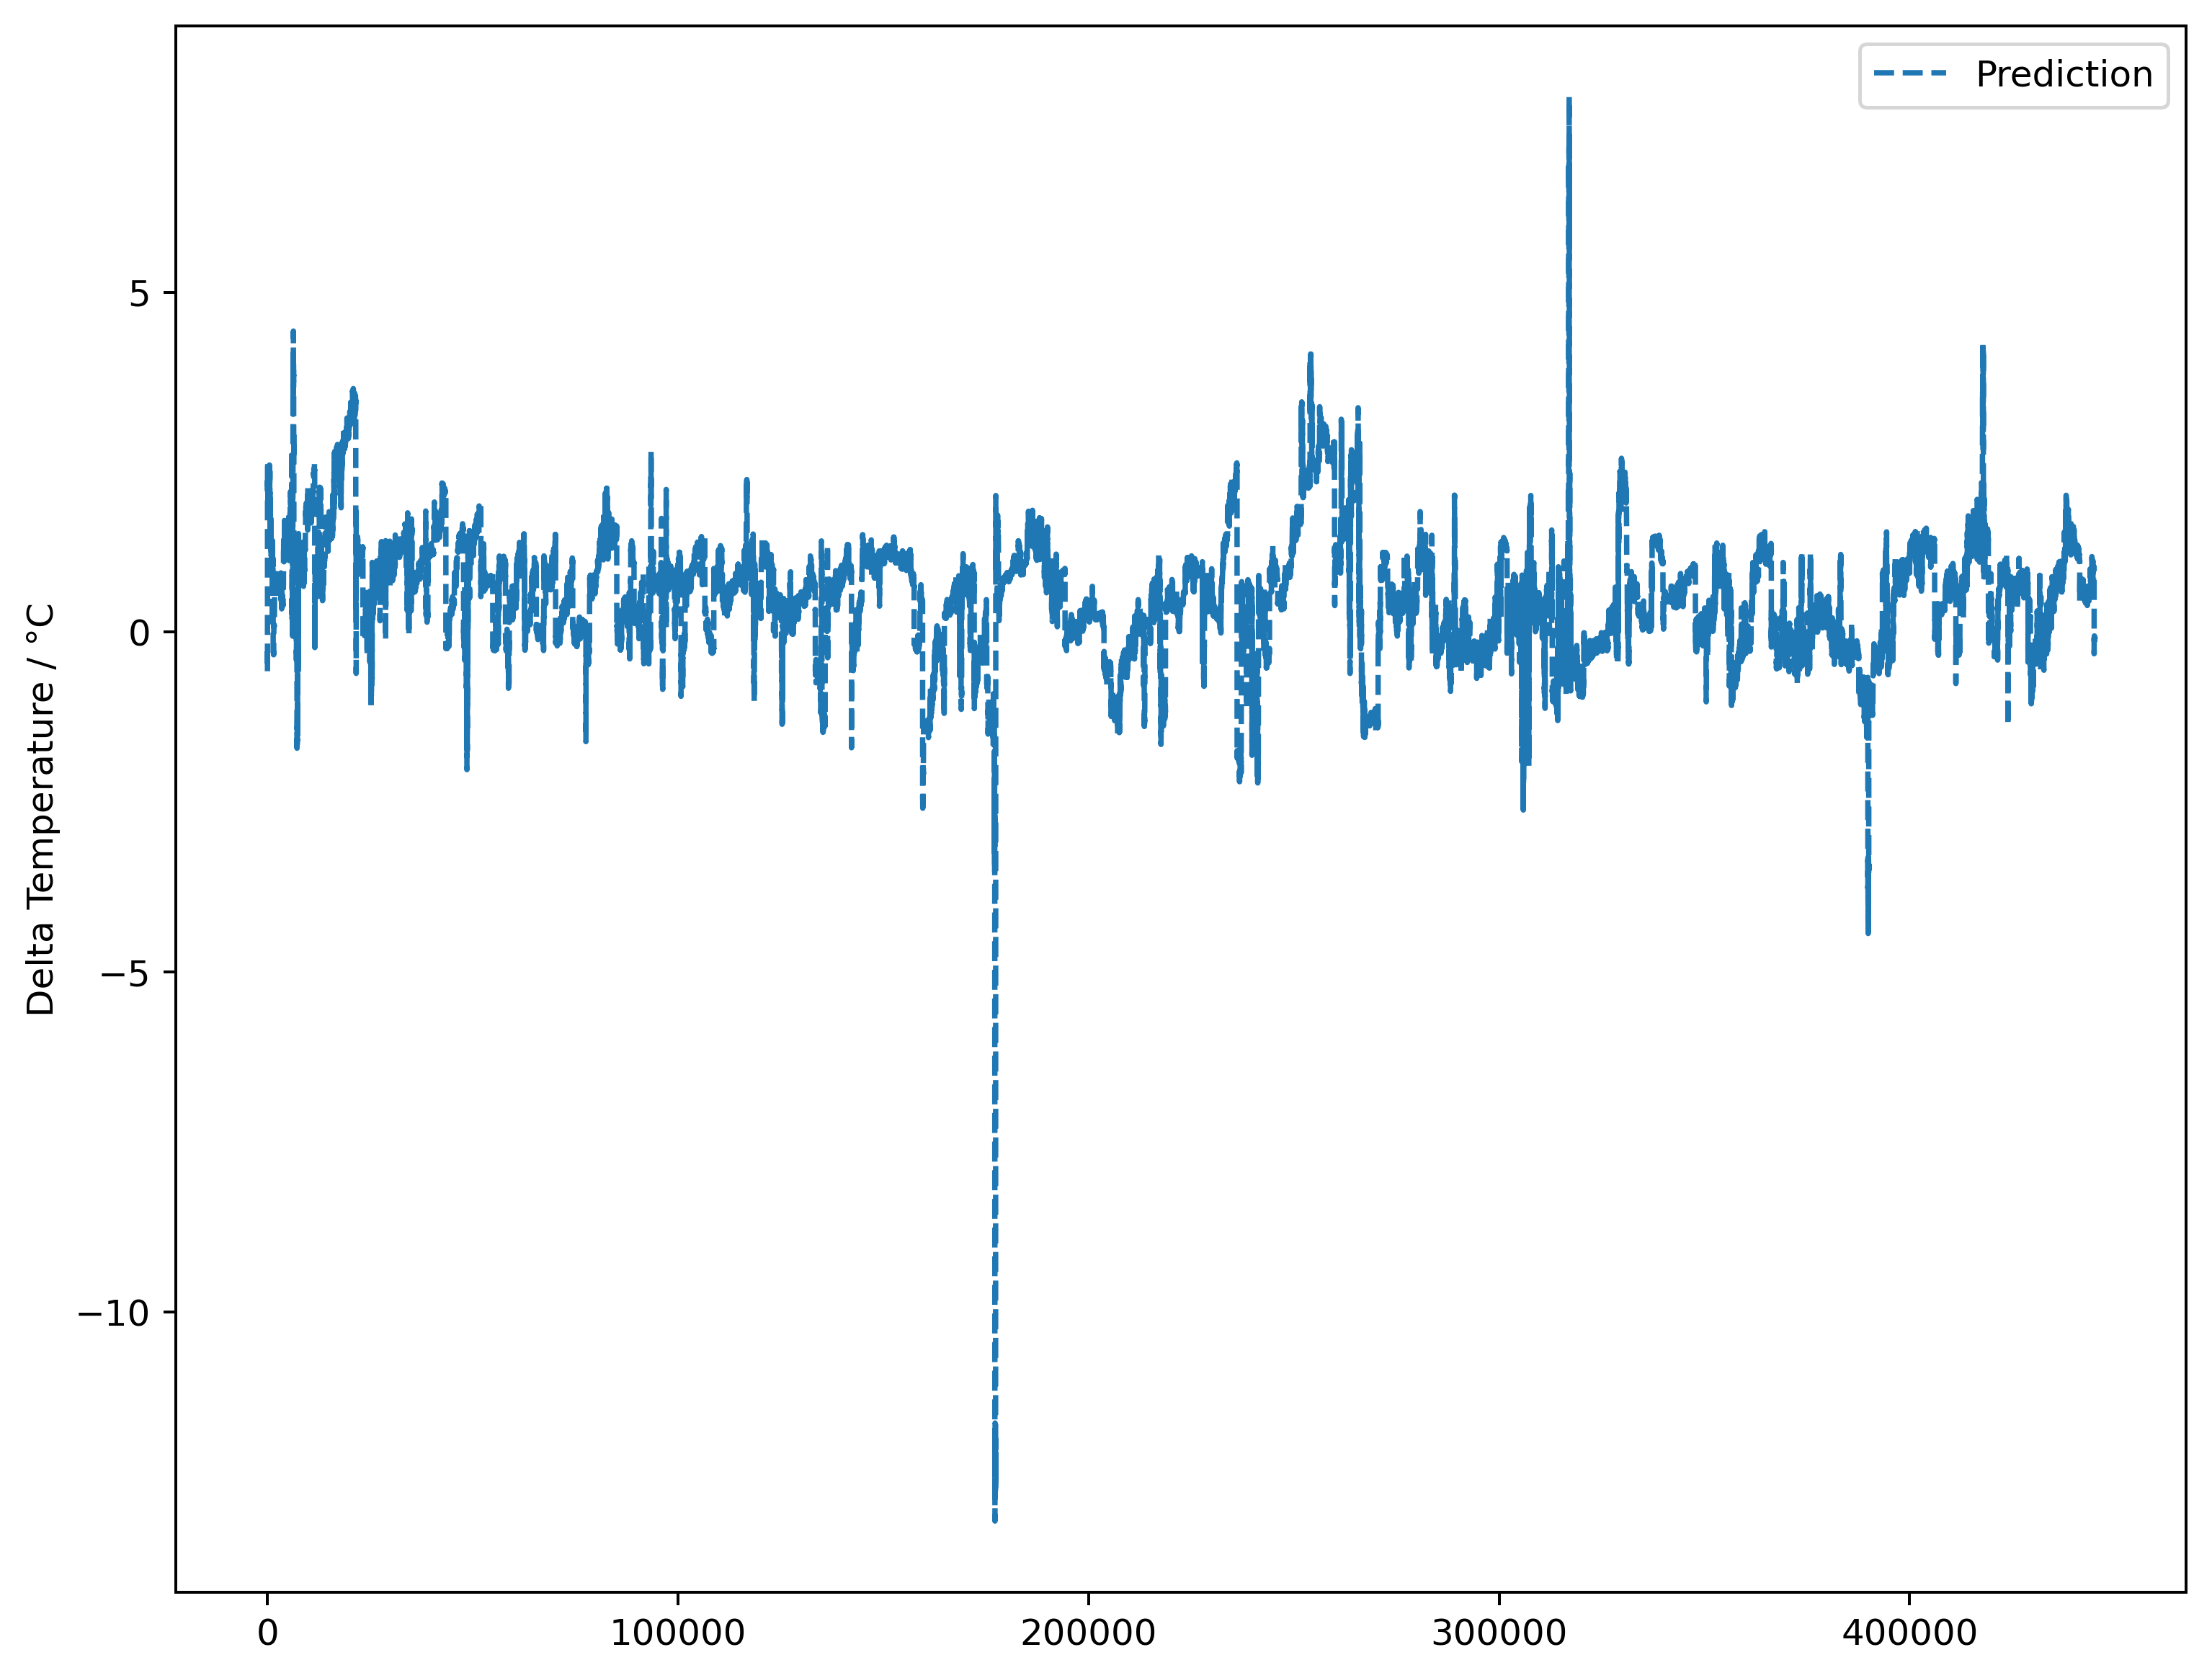

In [ ]:
figure(figsize=(10, 8), dpi= 360)

plt.plot(pred, '--')
#plt.plot(df_y_tensor_np, '-')
plt.legend(['Prediction'])
#plt.xlabel('time / min')
plt.ylabel('Delta Temperature / °C')
#plt.ylim([-0.01, 0.01])
plt.show()

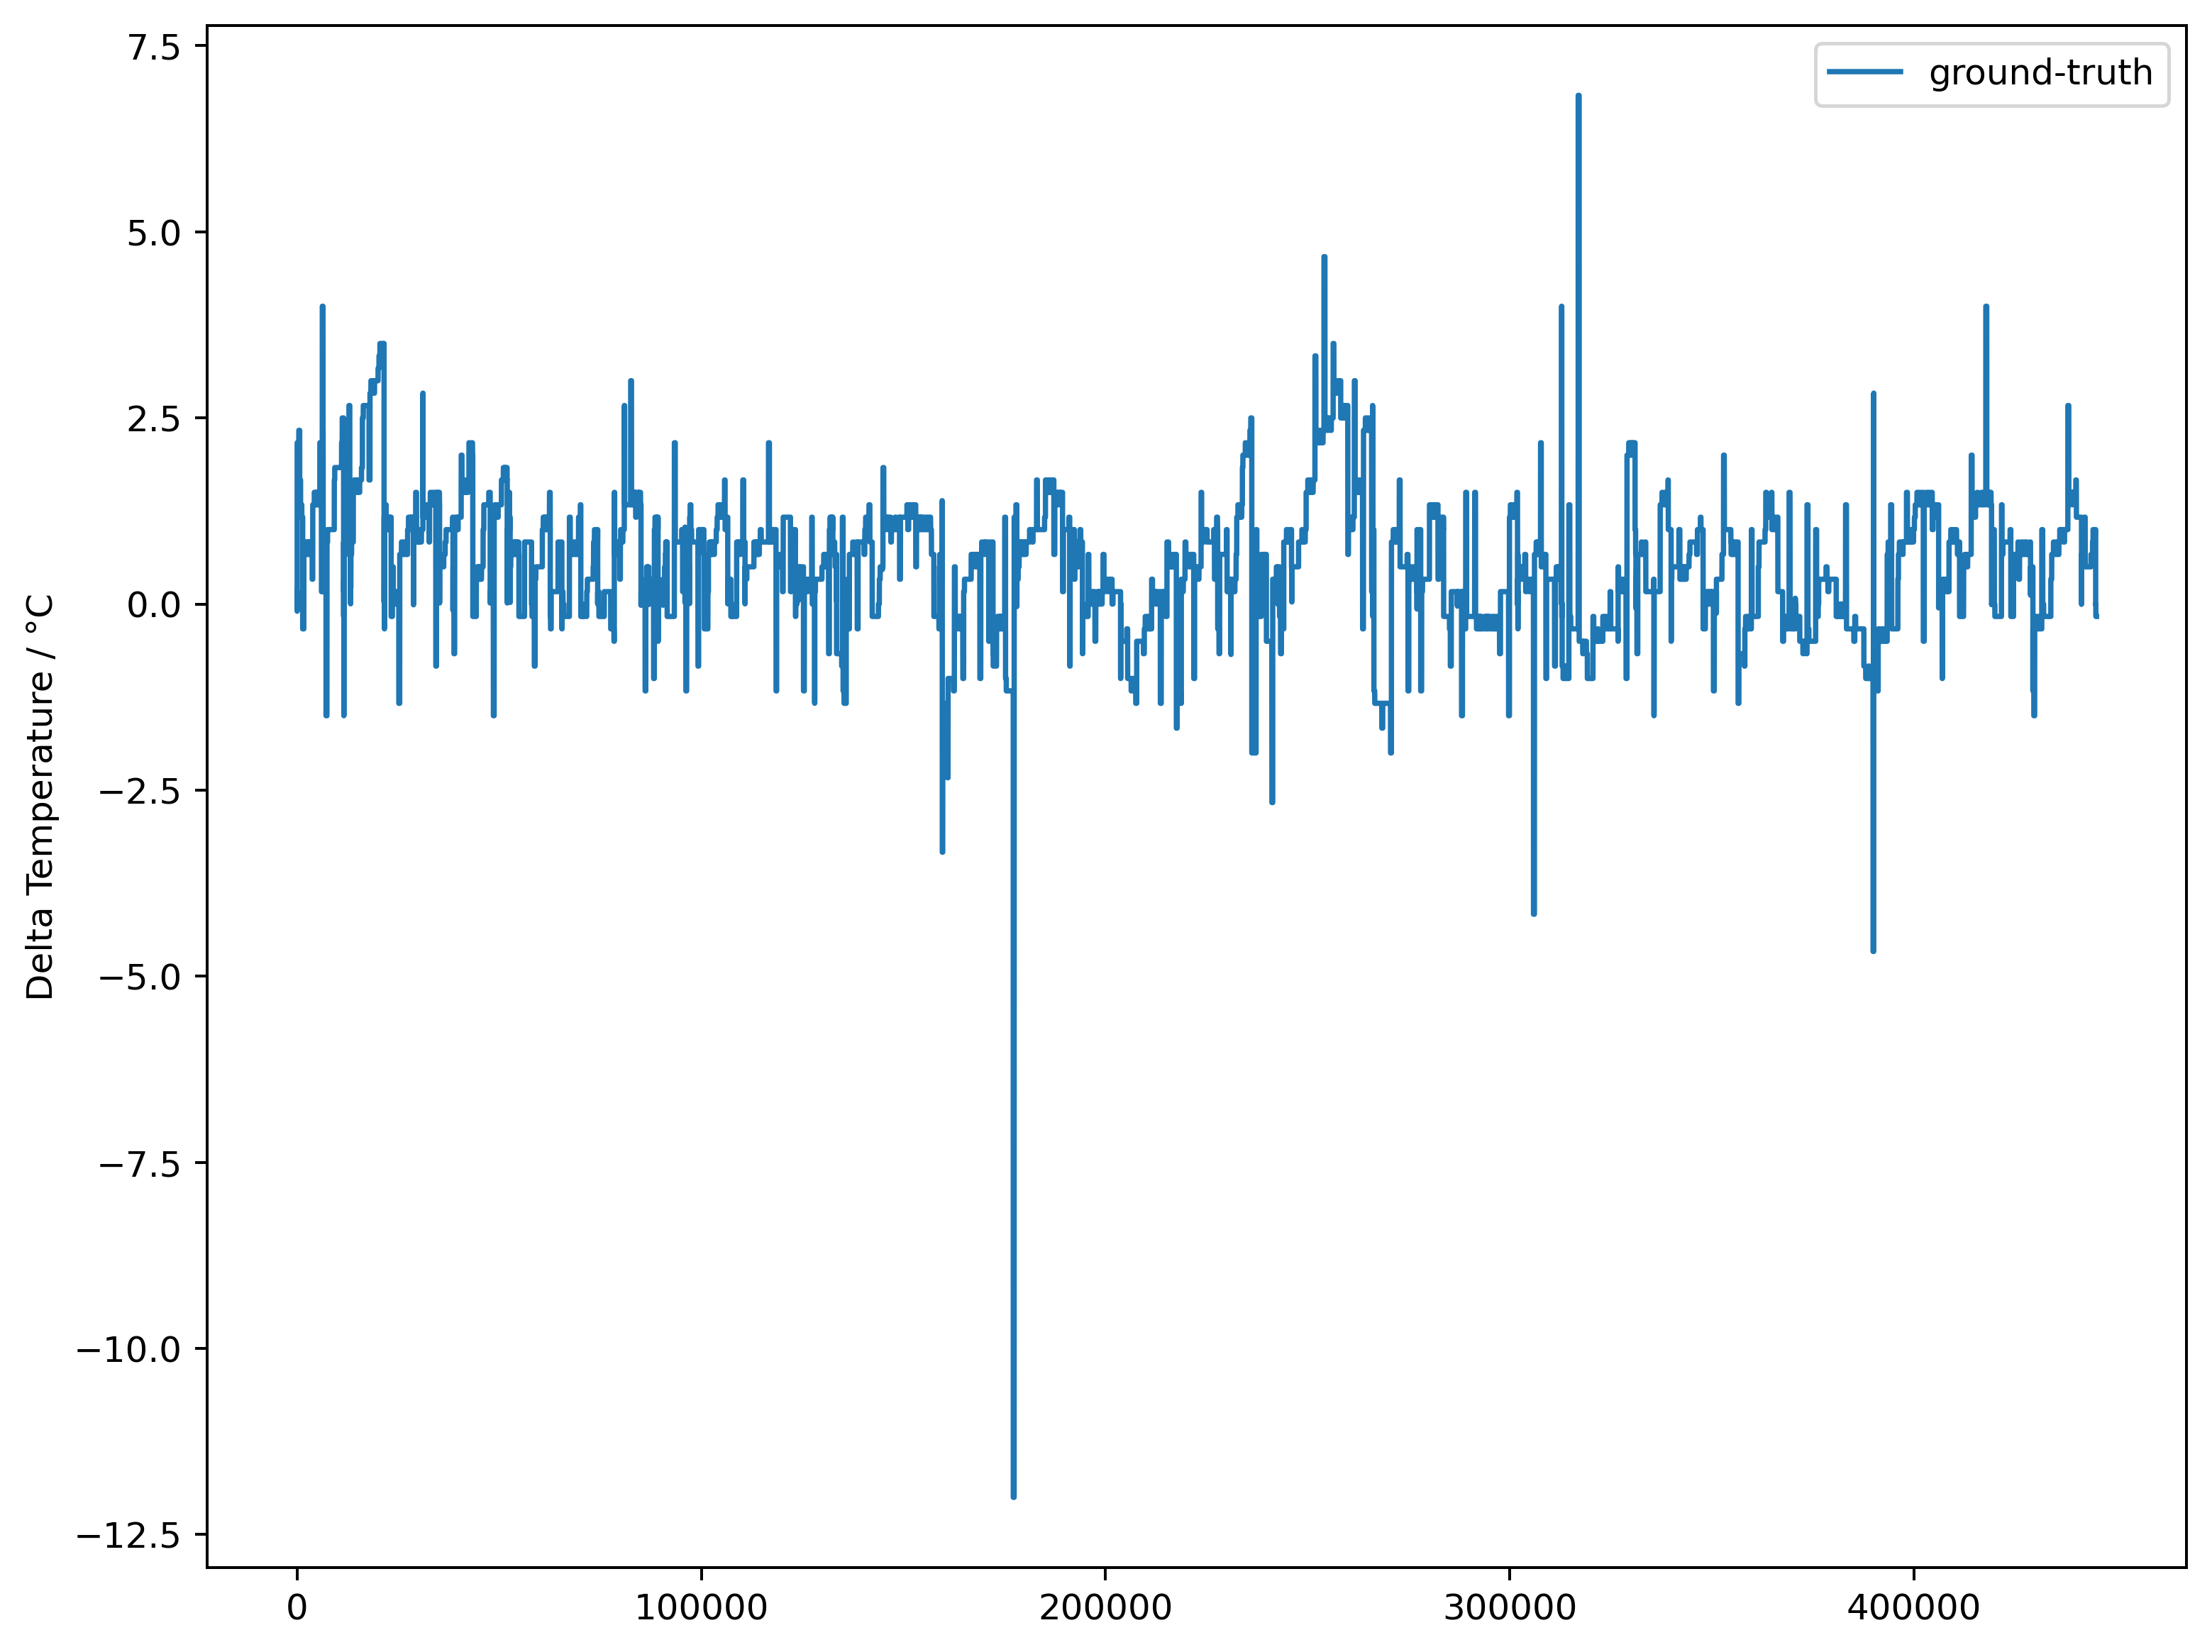

In [ ]:
figure(figsize=(10, 8), dpi= 360)

#plt.plot(pred, '--')
plt.plot(df_y_tensor_np, '-')
plt.legend(['ground-truth'])
#plt.xlabel('time / min')
plt.ylabel('Delta Temperature / °C')
#plt.ylim([-0.01, 0.01])
plt.show()

In [ ]:
class PDEDataset(Dataset):
    def __init__(self, nf, lb, ub):
        self.xf = lb + (ub - lb) * lhs(6, nf)

    def __getitem__(self, idx):
        """
        Returns data for initial state
        """
        return Tensor(self.xf).float()

    def __len__(self):
        """
        There exists no batch processing. So the size is 1
        """
        return 1

In [ ]:
# PDE
pde_dataset = PDEDataset(2000, lb, ub)

model2 = pf.models.MLP(input_size=6,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=lb, 
                      ub=ub)

model2.cuda() #GPU

def heat1d(x, u, model2):

    grads = ones(u.shape, device=u.device) # move to the same device as prediction
    grad_u = grad(u, x, create_graph=True, grad_outputs=grads)[0]

    # calculate first order derivatives
    #u_x = grad_u[:, 0]
    u_t = grad_u[:, 0]
  
    # calculate second order derivatives
    #grads = ones(u_x.shape, device=u.device)  # move to the same device as prediction
    #grad_u_x = grad(u_x, x, create_graph=True, grad_outputs=grads)[0]
    #u_xx = grad_u_x[:, 0]
    #print("u_xx", u_xx.shape)

    # reshape for correct behavior of the optimizer
    #u_x = u_x.reshape(-1, 1)
    u_t = u_t.reshape(-1, 1)
    #u_xx = u_xx.reshape(-1, 1)
    prediction = model(x)
    f = u_t - prediction

    return f  # concatenate real part and imaginary part

pde_loss = pf.PDELoss(pde_dataset, heat1d)

# create PINN instance
pinn = pf.PINN(model2, 6, 1, pde_loss, [], [], use_gpu=True)

# train pinn
pinn.fit(5000, checkpoint_path='checkpoint.pt', restart=True, lbfgs_finetuning=False)
pinn.load_model('best_model_pinn.pt')


TypeError: ignored

In [ ]:
#temp = new_clients_optional["ClientId_Count"]
#discrete_change_NCO = temp.diff()
#df0['delta_t'] = df0['date'].diff()
#print(df0['delta_t'])

#temp = df[df0["date"]].diff()
#print(temp)
#print(type(temp))
#delta_t = temp.diff()


In [ ]:
df0

In [ ]:
# Interpolate the missing data
df['outside_temp'] = df['outside_temp'].interpolate()
df['speed'] = df['speed'].interpolate()

In [ ]:
# Compute deltaTemp and add an additional column to dataset
df['deltaTemp'] = df['battery_temperature'].diff(periods=-1)*(-1)

In [ ]:
#Interpolate deltaTemp
df['deltaTemp'] = df['deltaTemp'].interpolate()

In [ ]:
#Remove transition points between different drives/dates
idx=(df['drive_id'].diff()[df['drive_id'].diff() != 0].index.values)
idx=idx-1
df = df.drop(idx[1:])


In [ ]:
# Remove values larger than 0.1
remove=(df['deltaTemp'][np.abs(df['deltaTemp']) >= 0.1].index.values)
df = df.drop(remove)


In [ ]:
plt.plot(df[["deltaTemp"]], '-')

In [ ]:
# Separate data to trainining and test data

np.random.seed(10)
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]


In [ ]:
# Extract features and labels for training dataset
#df_x = train[["power","speed", "battery_level", "outside_temp", "battery_temperature"]]
#df_y = train[["deltaTemp"]]
#print(df_y.shape)

In [ ]:
# Extract features and labels for all dataset
df_x = df[["power","speed", "battery_level", "outside_temp", "battery_temperature"]]
df_y = df[["deltaTemp"]]

df_x_tensor = (torch.tensor(df_x.values)).float()
df_y_tensor = torch.tensor(df_y.values).float()


In [ ]:
#MLP
lb = torch.min(df_x_tensor,0).values.numpy()
ub = torch.max(df_x_tensor,0).values.numpy()

model = pf.models.MLP(input_size=6,
                      output_size=1, 
                      hidden_size=100, 
                      num_hidden=4, 
                      lb=lb, 
                      ub=ub)

#model.cuda() #GPU

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
criterion = torch.nn.MSELoss()

In [ ]:
x_data_plot=[]
y_data_plot=[]
Epochs = 100
for epoch in range(Epochs):
    optimizer.zero_grad()
    #prediction = model(df_x_tensor.cuda()) #GPU
    prediction = model(df_x_tensor) #CPU
    #loss = criterion(prediction,df_y_tensor.cuda())  #GPU
    loss = criterion(prediction,df_y_tensor) #CPU
    loss.backward()
    optimizer.step()
    print("Epoch ", epoch, "Loss ", loss.item())
    x_data_plot.append(epoch)
    y_data_plot.append(loss.item())

# Make the plot of all the points together
plt.plot(x_data_plot,y_data_plot)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.ylim([0, 1])
plt.show()

In [ ]:
# Test data
#df_x = test[["power","speed", "battery_level", "outside_temp", "battery_temperature"]]
#df_y = test[["deltaTemp"]]
#df_x_tensor = (torch.tensor(df_x.values)).float()
#df_y_tensor = torch.tensor(df_y.values).float()

In [ ]:
# Make prediction
df_x_tensor=df_x_tensor
pred = model(df_x_tensor.float().cuda()) #GPU
#pred = model(df_x_tensor.float())

##pred = model(Tensor(X_star).cpu())
pred = pred.detach().cpu().numpy()

In [ ]:
df_y_tensor_np = df_y_tensor.numpy()

#comb = np.concatenate([df_y_tensor_np, pred],axis = 1)
#print(np.concatenate([df_y_tensor_np, pred],axis = 1))

print('relative l2 error:',(np.linalg.norm(df_y_tensor_np-pred)) / (np.linalg.norm(df_y_tensor_np)))

In [ ]:
from torch.nn import L1Loss, MSELoss

loss1 = MSELoss()
loss2 = L1Loss()
input = torch.from_numpy(pred)
target = df_y_tensor
MSE = loss1(input, target)
MAE = loss2(input, target)
print('MSE:', MSE)
print('MAE:', MAE)

In [ ]:
figure(figsize=(10, 8), dpi= 360)

plt.plot(pred, '--')
plt.plot(df_y_tensor_np, '-')
plt.legend(['Prediction', 'ground-truth'])
#plt.xlabel('time / min')
plt.ylabel('Delta Temperature / °C')
#plt.ylim([0, 0.01])
plt.show()

In [ ]:
figure(figsize=(10, 8), dpi= 360)

plt.plot(pred, '--')
#plt.plot(df_y_tensor_np, '-')
plt.legend(['Prediction'])
#plt.xlabel('time / min')
plt.ylabel('Delta Temperature / °C')
#plt.ylim([-0.01, 0.01])
plt.show()

In [ ]:
figure(figsize=(10, 8), dpi= 360)

#plt.plot(pred, '--')
plt.plot(df_y_tensor_np, '-')
plt.legend(['ground-truth'])
#plt.xlabel('time / min')
plt.ylabel('Delta Temperature / °C')
#plt.ylim([-0.01, 0.01])
plt.show()

In [ ]:
# Take one slice of the dataset
df50=df[df['drive_id'] == 50] # dataset for index=50
true = df50[["battery_temperature"]]

true = torch.tensor(true.values).float()
true = true.numpy()

s = np.zeros((df50.shape[0],1))
s[0] = true[0]

df_xx = df50[["power","speed", "battery_level", "outside_temp", "battery_temperature"]]
df_yy = df50[["deltaTemp"]]

df_xx_tensor = (torch.tensor(df_xx.values)).float()
df_yy_tensor = torch.tensor(df_yy.values).float()


In [ ]:
# Forward Euler Method for a given fixed initial conditions
for i in range(0, df50.shape[0] - 1):
    pred = model(df_xx_tensor[0].cuda())
    pred = pred.detach().cpu().numpy()
    s[i + 1] = s[i] + pred

#print(np.concatenate([true, s],axis = 1))
mse = ((true - s)**2).mean(axis=None)
print('MSE:', mse)

plt.figure(figsize = (12, 8))
plt.plot(s, '-', label='ODE approximation')
plt.plot(true, '--', label='Exact')
plt.title('Approximate and True Solution')
plt.xlabel('t-index')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Forward Euler method with updated T from data at each iteration
for i in range(0, df50.shape[0] - 1):
    pred = model(df_xx_tensor[i].cuda())
    pred = pred.detach().cpu().numpy()
    s[i + 1] = s[i] + pred

#print(np.concatenate([true, s],axis = 1))
mse = ((true - s)**2).mean(axis=None)
print('MSE:', mse)

plt.figure(figsize = (12, 8))
plt.plot(s, '-', label='ODE approximation')
plt.plot(true, '--', label='Exact')
plt.title('Approximate and True Solution')
plt.xlabel('t-index')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()



In [ ]:
# Forward Euler method with updated T from model at each iteration

input = df_xx_tensor[0]
print(type(input))
print(input[4])

for i in range(0, df50.shape[0] - 1):
      input = df_xx_tensor[i]
      input[4] = torch.tensor(s[i])
      pred = model(input.cuda())
      pred = pred.detach().cpu().numpy()
      s[i + 1] = s[i] + pred

#print(np.concatenate([true, s],axis = 1))

mse = ((true - s)**2).mean(axis=None)
print('MSE:', mse)

plt.figure(figsize = (12, 8))
plt.plot(s, '-', label='ODE approximation')
plt.plot(true, '--', label='Exact')
plt.title('Approximate and True Solution')
plt.xlabel('t-index')
plt.ylabel('Temperature')
plt.grid()
plt.legend(loc='lower right')
plt.show()
